# Assignment 1
**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, RNNs, Transformers, Huggingface



# Contact
For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

- Federico Ruggeri -> federico.ruggeri6@unibo.it
- Eleonora Mancini -> e.mancini@unibo.it

Professor:
- Paolo Torroni -> p.torroni@unibo.it

# Introduction
You are asked to address the [EXIST 2023 Task 2](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection.

## Problem Definition

This task aims to categorize the sexist messages according to the intention of the author in one of the following categories: (i) direct sexist message, (ii) reported sexist message and (iii) judgemental message.

### Examples:

#### DIRECT
The intention was to write a message that is sexist by itself or incites to be sexist, as in:

''*A woman needs love, to fill the fridge, if a man can give this to her in return for her services (housework, cooking, etc), I don’t see what else she needs.*''

#### REPORTED
The intention is to report and share a sexist situation suffered by a woman or women in first or third person, as in:

''*Today, one of my year 1 class pupils could not believe he’d lost a race against a girl.*''

#### JUDGEMENTAL
The intention was to judge, since the tweet describes sexist situations or behaviours with the aim of condemning them.

''*As usual, the woman was the one quitting her job for the family’s welfare…*''

# [Task 1 - 1.0 points] Corpus

We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2025-2026/Assignment%201/data).

Check the `A1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.


### Dataset Description
- The dataset contains tweets in both English and Spanish.
- There are labels for multiple tasks, but we are focusing on **Task 2**.
- For Task 2, labels are assigned by six annotators.
- The labels for Task 2 represent whether the tweet is non-sexist ('-') or its sexist intention ('DIRECT', 'REPORTED', 'JUDGEMENTAL').







### Example

```
    "203260": {
        "id_EXIST": "203260",
        "lang": "en",
        "tweet": "ik when mandy says “you look like a whore” i look cute as FUCK",
        "number_annotators": 6,
        "annotators": ["Annotator_473", "Annotator_474", "Annotator_475", "Annotator_476", "Annotator_477", "Annotator_27"],
        "gender_annotators": ["F", "F", "M", "M", "M", "F"],
        "age_annotators": ["18-22", "23-45", "18-22", "23-45", "46+", "46+"],
        "labels_task1": ["YES", "YES", "YES", "NO", "YES", "YES"],
        "labels_task2": ["DIRECT", "DIRECT", "REPORTED", "-", "JUDGEMENTAL", "REPORTED"],
        "labels_task3": [
          ["STEREOTYPING-DOMINANCE"],
          ["OBJECTIFICATION"],
          ["SEXUAL-VIOLENCE"],
          ["-"],
          ["STEREOTYPING-DOMINANCE", "OBJECTIFICATION"],
          ["OBJECTIFICATION"]
        ],
        "split": "TRAIN_EN"
      }
    }
```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install emoji
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 31.9 MB/s eta 0:00:00


In [ ]:
from pathlib import Path
import simplejson as sj

import pandas as pd
import keras
from sklearn.preprocessing import LabelEncoder
import nltk
import re
import numpy as np
import emoji
from tqdm import tqdm
# typing
from typing import List, Callable, Dict
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

In [ ]:
epochs_run = 10
seeds = [42, 111, 321]
checkpoint_path = "/content/drive/My Drive/nlp_assignment1_model_checkpoint.keras"

# Modified ModelCheckpoint to monitor 'val_f1' for consistency with model selection
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_f1',
    mode='max', # since f1 is better when higher
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)


In [ ]:
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

### Instructions
1. **Download** the `A1/data` folder.
2. **Load** the three JSON files and encode them as ``pandas.DataFrame``.
3. **Aggregate labels** for Task 2 using majority voting and store them in a new dataframe column called `label`. Items without a clear majority will be removed from the dataset.
4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.
5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `label`.
6. **Encode the `label` column**: Use the following mapping

```
{
    '-': 0,
    'DIRECT': 1,
    'JUDGEMENTAL': 2,
    'REPORTED': 3
}
```

In [ ]:
def downloadDataFromGitHub(url):
  return  pd.DataFrame(pd.read_json(url, orient='index'))

url_temp = 'https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2025-2026/Assignment%201/data/'
files = ['training.json', 'test.json', 'validation.json']

In [ ]:
df_train = downloadDataFromGitHub(url_temp + files[0])
df_test = downloadDataFromGitHub(url_temp + files[1])
df_val = downloadDataFromGitHub(url_temp + files[2])

In [ ]:
print(f'Training data =  {df_train.shape}')
print(f'Test data =  {df_test.shape}')
print(f'Val data =  {df_val.shape}')
print('')
print('A look at train data')
df_train.head()

Training data =  (6920, 11)
Test data =  (312, 11)
Val data =  (726, 11)

A look at train data


,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
100001,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES
100002,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES
100003,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES
100004,100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"[Annotator_13, Annotator_14, Annotator_15, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, YES, NO, YES, YES]","[-, -, DIRECT, -, REPORTED, REPORTED]","[[-], [-], [IDEOLOGICAL-INEQUALITY], [-], [IDE...",TRAIN_ES
100005,100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"[Annotator_19, Annotator_20, Annotator_21, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",TRAIN_ES


In [ ]:
def maj_label2(df_original):
    df = df_original.copy()
    labels_exploded = pd.DataFrame(df['labels_task2'].tolist(), index=df.index)

    def get_majority_label(row_labels):
        value_counts = pd.Series(row_labels).value_counts()
        if value_counts.empty:
            return np.nan # No labels
        max_count = value_counts.max()

        # Check for clear majority: at least 3 votes for one label AND it must be unique max
        if max_count >= 3:
            majority_candidates = value_counts[value_counts == max_count].index.tolist()
            if len(majority_candidates) == 1:
                return majority_candidates[0]
        return np.nan # No clear majority (tie or less than 3 votes)

    df['label'] = labels_exploded.apply(get_majority_label, axis=1)

    # Remove rows where a clear majority could not be determined
    df.dropna(subset=['label'], inplace=True)

    return df

In [ ]:
columns_to_drop = ['number_annotators', 'annotators', 'gender_annotators', 'age_annotators', 'labels_task1', 'labels_task2', 'labels_task3', 'split']

def handle_data(df):

  df_copy = df.copy()
  df_maj = maj_label2(df_copy)
  df_en = df_maj[df_maj['lang']=='en']
  df_drop = df_en.drop(columns_to_drop, axis=1)
  return df_drop

In [ ]:
df_train = handle_data(df_train)
df_test = handle_data(df_test)
df_val = handle_data(df_val)

df_train.head()

,id_EXIST,lang,tweet,label
200001,200001,en,FFS! How about laying the blame on the bastard...,-
200002,200002,en,Writing a uni essay in my local pub with a cof...,REPORTED
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,REPORTED
200004,200004,en,@GMB this is unacceptable. Use her title as yo...,-
200005,200005,en,‘Making yourself a harder target’ basically bo...,-


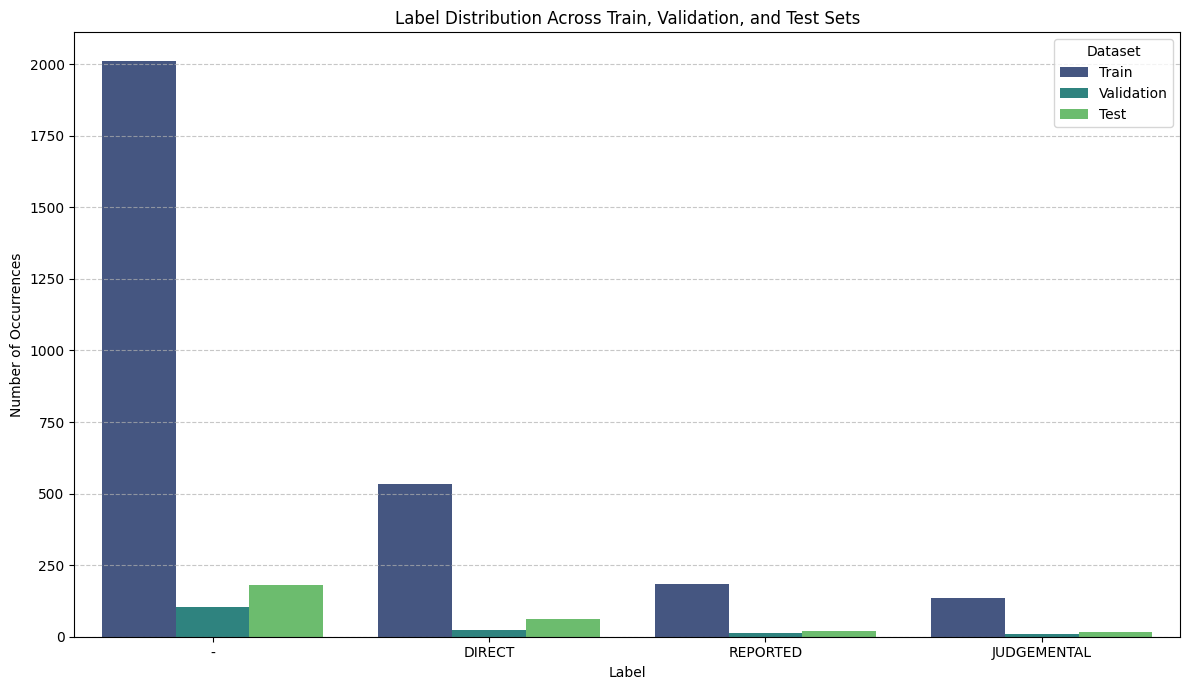

In [ ]:
# Get value counts for each dataframe
train_counts = df_train['label'].value_counts().reset_index()
train_counts.columns = ['label_id', 'count']
train_counts['dataset'] = 'Train'

val_counts = df_val['label'].value_counts().reset_index()
val_counts.columns = ['label_id', 'count']
val_counts['dataset'] = 'Validation'

test_counts = df_test['label'].value_counts().reset_index()
test_counts.columns = ['label_id', 'count']
test_counts['dataset'] = 'Test'

# Combine all counts into a single DataFrame
all_counts = pd.concat([train_counts, val_counts, test_counts])

# Map label IDs back to their names
all_counts['label_name'] = all_counts['label_id']

# Create the bar plot
plt.figure(figsize=(12, 7))
sns.barplot(x='label_name', y='count', hue='dataset', data=all_counts, palette='viridis')
plt.title('Label Distribution Across Train, Validation, and Test Sets')
plt.xlabel('Label')
plt.ylabel('Number of Occurrences')
plt.legend(title='Dataset')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

###ANALYSIS
Our data is heavily skewed with non-sexist annotated tweets. Remember to cater it in the model

In [ ]:
label_encoding = {
    '-': 0,
    'DIRECT': 1,
    'JUDGEMENTAL': 2,
    'REPORTED': 3
}

label_encoding_reverse = {
    0: '-',
    1: 'DIRECT',
    2: 'JUDGEMENTAL',
    3: 'REPORTED'
}

df_train['label'] = df_train['label'].map(label_encoding)
df_test['label'] = df_test['label'].map(label_encoding)
df_val['label'] = df_val['label'].map(label_encoding)

y_train = df_train['label'].values
y_val = df_val['label'].values
y_test = df_test['label'].values

df_train.head()

,id_EXIST,lang,tweet,label
200001,200001,en,FFS! How about laying the blame on the bastard...,0
200002,200002,en,Writing a uni essay in my local pub with a cof...,3
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,3
200004,200004,en,@GMB this is unacceptable. Use her title as yo...,0
200005,200005,en,‘Making yourself a harder target’ basically bo...,0


# [Task2 - 0.5 points] Data Cleaning
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.



### Instructions
- **Remove emojis** from the tweets.
- **Remove hashtags** (e.g., `#example`).
- **Remove mentions** such as `@user`.
- **Remove URLs** from the tweets.
- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form.

In [ ]:
def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')

In [ ]:
def clean_text(df_original):
  df = df_original.copy()

  # remove links
  df.loc[:, "tweet"] = df.loc[:, "tweet"].replace(r'http\S+', '', regex=True)
  # Remove hashtags
  df.loc[:, "tweet"] = df.loc[:, "tweet"].replace(r'#\w+', '', regex=True)
  # remove mentions
  df.loc[:, "tweet"] = df.loc[:, "tweet"].replace(r'@\w+', '', regex=True)
  # remove emoji
  df.loc[:, "tweet"] = df.loc[:, "tweet"].apply(remove_emojis)

  # remove special characters and quote characters (preserving letter, number, and spaces)
  df.loc[:, "tweet"] = df.loc[:, "tweet"].replace(r'[^A-Za-z0-9\s]', '', regex=True)

  # Strip whitespace and then filter out empty strings
  initial_rows = len(df)
  df['tweet'] = df['tweet'].str.strip()
  df = df[df['tweet'] != '']
  print(f"Clean_text function removed {initial_rows - len(df)} rows due to empty tweets.")

  return df

In [ ]:
df_train = clean_text(df_train)
df_test = clean_text(df_test)
df_val = clean_text(df_val)

Clean_text function removed 0 rows due to empty tweets.
Clean_text function removed 0 rows due to empty tweets.
Clean_text function removed 0 rows due to empty tweets.


In [ ]:
print(f'Training data =  {df_train.shape}')
print(f'Test data =  {df_test.shape}')
print(f'Val data =  {df_val.shape}')
print('')
print('A look at train data')
df_train.head()

Training data =  (2867, 4)
Test data =  (280, 4)
Val data =  (150, 4)

A look at train data


,id_EXIST,lang,tweet,label
200001,200001,en,FFS How about laying the blame on the bastard ...,0
200002,200002,en,Writing a uni essay in my local pub with a cof...,3
200003,200003,en,it is 2021 not 1921 I dont appreciate that on ...,3
200004,200004,en,this is unacceptable Use her title as you did ...,0
200005,200005,en,Making yourself a harder target basically boil...,0


In [ ]:
from nltk.tokenize import word_tokenize, sent_tokenize, WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import pos_tag
from nltk.corpus import wordnet, stopwords

stemmer = SnowballStemmer("english")
tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

In [ ]:
def stem_text(text: str):
    words = [stemmer.stem(word) for word in tokenizer.tokenize(text)]
    return " ".join(words)

def get_wordnet_key(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

def lem_text(text: str):
    tokens = tokenizer.tokenize(text)
    tagged = pos_tag(tokens)
    words = [lemmatizer.lemmatize(word, get_wordnet_key(tag))
             for word, tag in tagged]
    return " ".join(words)

def lem_stem(text: str):
  stemmed = stem_text(text)
  lemmed = lem_text(stemmed)
  return lemmed

In [ ]:
print('start process to stem and lem it')
df_train['tweet'] = [lem_stem(tweet) for tweet in tqdm(df_train.tweet.values)]
df_test['tweet'] = [lem_stem(tweet) for tweet in tqdm(df_test.tweet.values)]
df_val['tweet'] = [lem_stem(tweet) for tweet in tqdm(df_val.tweet.values)]


print(df_train.shape)
df_train.head()

start process to stem and lem it


100%|██████████| 150/150 [00:00<00:00, 362.61it/s]


(2867, 4)


,id_EXIST,lang,tweet,label
200001,200001,en,ffs how about lay the blame on the bastard who...,0
200002,200002,en,write a uni essay in my local pub with a coffe...,3
200003,200003,en,it be 2021 not 1921 i dont appreci that on two...,3
200004,200004,en,this be unaccept use her titl a you do for all...,0
200005,200005,en,make yourself a hard target basic boil down to...,0


# [Task 3 - 0.5 points] Text Encoding
To train a neural sexism classifier, you first need to encode text into numerical format.




### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.





### What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., ``<UNK>``) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)



### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!

In [ ]:
# First build a vocabulary
def build_vocabulary(
    df: pd.DataFrame
) -> (Dict[int, str], Dict[str, int], List[str]):
    """
    Given a dataset, builds the corresponding word vocabulary.

    :param df: dataset from which we want to build
    the word vocabulary (pandas.DataFrame)
    :return:
      - word vocabulary: vocabulary index to word
      - inverse word vocabulary: word to vocabulary index
      - word listing: set of unique terms that build up the vocabulary
    """
    idx_to_word = OrderedDict()
    word_to_idx = OrderedDict()

    # Reserve 0 for padding token
    word_to_idx["<PAD>"] = 0
    idx_to_word[0] = "<PAD>"

    curr_idx = 1 # Start actual word indexing from 1
    for sentence in df.tweet.values:
        tokens = sentence.split()
        for token in tokens:
            if token not in word_to_idx:
                word_to_idx[token] = curr_idx
                idx_to_word[curr_idx] = token
                curr_idx += 1

    word_listing = list(idx_to_word.values())
    return idx_to_word, word_to_idx, word_listing

In [ ]:
idx_to_word, word_to_idx, word_listing = build_vocabulary(df_train)

# Ensure <UNK> token is in vocabulary, assigning it the next available index
if "<UNK>" not in word_to_idx:
  word_to_idx["<UNK>"] = len(word_to_idx)
  idx_to_word[word_to_idx["<UNK>"]] = "<UNK>"
  word_listing.append("<UNK>")


vocab_size = len(idx_to_word)
# Print some words, skipping index 0 as it's now <PAD>
some_words = [(idx_to_word[idx], idx) for idx in np.arange(1, min(11, vocab_size))]
print(f'Some words: {some_words}')

vocab_path = Path.cwd().joinpath('vocab.json')

print(f"Saving vocabulary to {vocab_path}")
with vocab_path.open(mode='w') as f:
    sj.dump(word_to_idx, f, indent=4)
print("Saving completed!")

Some words: [('ffs', np.int64(1)), ('how', np.int64(2)), ('about', np.int64(3)), ('lay', np.int64(4)), ('the', np.int64(5)), ('blame', np.int64(6)), ('on', np.int64(7)), ('bastard', np.int64(8)), ('who', np.int64(9)), ('murder', np.int64(10))]
Saving vocabulary to /content/vocab.json
Saving completed!


In [ ]:
import gensim
import gensim.downloader as gloader

download_path = "glove-twitter-50"
glove_emb_model = gloader.load(download_path)

[==================================================] 100.0% 199.5/199.5MB downloaded


In [ ]:
def check_OOV_terms(embedding_model, word_listing):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [ ]:
oov_terms = check_OOV_terms(glove_emb_model, word_listing)
oov_percentage = float(len(oov_terms)) * 100 / len(word_listing)
print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")

Total OOV terms: 2743 (31.52%)


In [ ]:
def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int],
                           vocab_size: int,
                           oov_terms: List[str]) -> np.ndarray:

    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    for word, idx in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [ ]:
embedding_dimension = 50
embedding_matrix = build_embedding_matrix(glove_emb_model,
                                          embedding_dimension,
                                          word_to_idx,
                                          len(word_to_idx),
                                          oov_terms)
print(f"\nEmbedding matrix shape: {embedding_matrix.shape}")

100%|██████████| 8703/8703 [00:00<00:00, 294391.13it/s]


Embedding matrix shape: (8703, 50)


In [ ]:
def encode_text(text, word_to_idx):
    tokens = text.split()
    unk_id = word_to_idx['<UNK>']

    # Look up word. If missing, return unk_id
    return [word_to_idx.get(word, unk_id) for word in tokens]

# Apply Encoding
X_train = df_train['tweet'].apply(lambda x: encode_text(x, word_to_idx))
X_val   = df_val['tweet'].apply(lambda x: encode_text(x, word_to_idx))
X_test  = df_test['tweet'].apply(lambda x: encode_text(x, word_to_idx))

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

# Pad sequences with the token ID for <PAD>, which is now 0
X_train_padded = pad_sequences(X_train, maxlen=max_len, padding='post', value=word_to_idx['<PAD>'])
X_val_padded   = pad_sequences(X_val, maxlen=max_len, padding='post', value=word_to_idx['<PAD>'])
X_test_padded   = pad_sequences(X_test, maxlen=max_len, padding='post', value=word_to_idx['<PAD>'])


# [Task 4 - 1.0 points] Model definition

You are now tasked to define your sexism classifier.




### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.

* **Stacked**: add an additional Bidirectional LSTM layer to the Baseline model.

**Note**: You are **free** to experiment with hyper-parameters.

### Token to embedding mapping

You can follow two approaches for encoding tokens in your classifier.

### Work directly with embeddings

- Compute the embedding of each input token
- Feed the mini-batches of shape ``(batch_size, # tokens, embedding_dim)`` to your model

### Work with Embedding layer

- Encode input tokens to token ids
- Define a Embedding layer as the first layer of your model
- Compute the embedding matrix of all known tokens (i.e., tokens in your vocabulary)
- Initialize the Embedding layer with the computed embedding matrix
- You are **free** to set the Embedding layer trainable or not

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def compute_metrics(output_info):
    predictions, labels = output_info
    predictions = np.argmax(predictions, axis=-1)

    f1 = f1_score(y_pred=predictions, y_true=labels, average='macro')
    acc = accuracy_score(y_pred=predictions, y_true=labels)
    precision = precision_score(y_pred=predictions, y_true=labels, average='macro', zero_division=0)
    recall = recall_score(y_pred=predictions, y_true=labels, average='macro', zero_division=0)

    return {'f1': f1, 'acc': acc, 'precision': precision, 'recall': recall}

In [ ]:
def plot_acc(history):
  values = history.history
  val_loss = values['val_loss']
  training_loss = values['loss']
  training_acc = values['accuracy']
  validation_acc = values['val_accuracy']
  epochs = range(epochs_run)

  plt.figure(figsize=(8, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, val_loss, label = 'Validation Loss')
  plt.plot(epochs, training_loss, label = 'Training Loss')
  plt.title('Epochs vs Loss')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(epochs, training_acc, label = 'Training Accuracy')
  plt.plot(epochs, validation_acc, label = 'Validation Accuracy')
  plt.title('Epochs vs Accuracy')
  plt.legend()
  plt.show()

In [ ]:
from keras import layers

def create_bi_lstm_model(embedding_matrix, embedding_dimension, vocab_size, num_classes, double, model_name='', learning_rate=0.001):

  inputs = keras.Input(shape=(None,), dtype="int32")
  x = layers.Embedding(vocab_size, embedding_dimension, weights=[embedding_matrix], trainable=False, mask_zero=True, name='encoder_embedding')(inputs)

  x = layers.SpatialDropout1D(0.2)(x)

  if double:
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, recurrent_dropout=0.1))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=False, recurrent_dropout=0.1))(x)
  else:
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=False, recurrent_dropout=0.1))(x)

  x = layers.Dropout(0.5)(x)

  # Add a classifier
  outputs = layers.Dense(num_classes, activation="softmax")(x)
  model = keras.Model(inputs, outputs, name=model_name)
  model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])

  return model


# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline and Stacked models.



### Instructions

* Pick **at least** three seeds for robust estimation.
* Train **all** models on the train set.
* Evaluate **all** models on the validation and test sets.
* Compute macro F1-score, precision, and recall metrics on the validation set.
* Report average and standard deviation measures over seeds for each metric.
* Pick the **best** performing model according to the observed validation set performance (use macro F1-score).

In [ ]:
models = ['baseline', 'stacked']
accuracy_scores = []
f1_scores = []
histories = []
all_models = []
precision_scores = []
recall_scores = []

# learning rate for the models
learning_rate_lstm = 0.001

for seed in seeds:
  np.random.seed(seed)
  tf.random.set_seed(seed)
  for model_type in models:
    print(f'For {model_type} with {seed}')
    if model_type == 'baseline':
      model = create_bi_lstm_model(embedding_matrix, embedding_dimension, vocab_size, 4, False, model_name=f'{model_type}_{seed}', learning_rate=learning_rate_lstm)
    else:
      model = create_bi_lstm_model(embedding_matrix, embedding_dimension, vocab_size, 4, True, model_name=f'{model_type}_{seed}', learning_rate=learning_rate_lstm)

    all_models.append(model)

    # Pass the callback to model.fit
    history = model.fit(X_train_padded, y_train, epochs=epochs_run, batch_size=256, validation_data=(X_val_padded, y_val), callbacks=[cp_callback])
    histories.append(history)

    y_pred_val = model.predict(X_val_padded)

    metrics = compute_metrics((y_pred_val, y_val))

    accuracy_scores.append(metrics['acc'])
    f1_scores.append(metrics['f1'])
    precision_scores.append(metrics['precision'])
    recall_scores.append(metrics['recall'])

    print(f"Run Result: F1={metrics['f1']:.4f}, Acc={metrics['acc']:.4f}, Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}")


For baseline with 42
Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.6105 - loss: 1.0822

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_f1 available.
  if self._should_save_model(epoch, batch, logs, filepath):


12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 717ms/step - accuracy: 0.6146 - loss: 1.0776 - val_accuracy: 0.7000 - val_loss: 0.9184
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 326ms/step - accuracy: 0.7095 - loss: 0.8633 - val_accuracy: 0.6933 - val_loss: 0.8966
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 315ms/step - accuracy: 0.7134 - loss: 0.8544 - val_accuracy: 0.7000 - val_loss: 0.8638
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 403ms/step - accuracy: 0.7134 - loss: 0.8228 - val_accuracy: 0.7133 - val_loss: 0.8421
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 345ms/step - accuracy: 0.7179 - loss: 0.7969 - val_accuracy: 0.7133 - val_loss: 0.8250
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 330ms/step - accuracy: 0.7236 - loss: 0.7874 - val_accuracy: 0.7200 - val_loss: 0.8155
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 430ms/step - accuracy: 0.7198 - loss: 0.7774 - val_accuracy: 0.7200 - val_loss: 0.8230
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 316ms/step - accuracy: 0.7238 - loss: 0.7682 - val_accuracy: 0.7267 - val

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_f1 available.
  if self._should_save_model(epoch, batch, logs, filepath):


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 648ms/step - accuracy: 0.7111 - loss: 0.8699 - val_accuracy: 0.7067 - val_loss: 0.8632
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7078 - loss: 0.8286 - val_accuracy: 0.7067 - val_loss: 0.8373
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 665ms/step - accuracy: 0.7129 - loss: 0.8011 - val_accuracy: 0.7067 - val_loss: 0.8066
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 741ms/step - accuracy: 0.7225 - loss: 0.7771 - val_accuracy: 0.7133 - val_loss: 0.7999
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 794ms/step - accuracy: 0.7112 - loss: 0.7748 - val_accuracy: 0.7267 - val_loss: 0.7956
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 658ms/step - accuracy: 0.7179 - loss: 0.7752 - val_accuracy: 0.7133 - val_loss: 0.7955
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 658ms/step - accuracy: 0.7179 - loss: 0.7576 - val_accuracy: 0.7200 - val_loss: 0.7554
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 756ms/step - accuracy: 0.7293 - loss: 0.7400 - val_accuracy: 0.7200 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_f1 available.
  if self._should_save_model(epoch, batch, logs, filepath):


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 328ms/step - accuracy: 0.7058 - loss: 0.8702 - val_accuracy: 0.7067 - val_loss: 0.8703
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 336ms/step - accuracy: 0.6990 - loss: 0.8434 - val_accuracy: 0.7267 - val_loss: 0.8368
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 607ms/step - accuracy: 0.7082 - loss: 0.8105 - val_accuracy: 0.7133 - val_loss: 0.8039
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 647ms/step - accuracy: 0.7144 - loss: 0.7863 - val_accuracy: 0.7200 - val_loss: 0.7912
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 800ms/step - accuracy: 0.7142 - loss: 0.7828 - val_accuracy: 0.7200 - val_loss: 0.7720
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 675ms/step - accuracy: 0.7155 - loss: 0.7584 - val_accuracy: 0.7333 - val_loss: 0.7683
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 596ms/step - accuracy: 0.7174 - loss: 0.7590 - val_accuracy: 0.7333 - val_loss: 0.7646
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 630ms/step - accuracy: 0.7234 - loss: 0.7463 - val_accuracy: 0.7333 - val

4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step
Run Result: F1=0.3604, Acc=0.7400, Precision=0.4442, Recall=0.3591
For stacked with 111
Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 881ms/step - accuracy: 0.5883 - loss: 1.1286 - val_accuracy: 0.7000 - val_loss: 0.9017
Epoch 2/10


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_f1 available.
  if self._should_save_model(epoch, batch, logs, filepath):


12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 663ms/step - accuracy: 0.7056 - loss: 0.8744 - val_accuracy: 0.7267 - val_loss: 0.8606
Epoch 3/10


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_f1 available.
  if self._should_save_model(epoch, batch, logs, filepath):


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 755ms/step - accuracy: 0.7115 - loss: 0.8247 - val_accuracy: 0.7200 - val_loss: 0.8247
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7054 - loss: 0.8121 - val_accuracy: 0.7267 - val_loss: 0.7910
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 845ms/step - accuracy: 0.7142 - loss: 0.7876 - val_accuracy: 0.7200 - val_loss: 0.8132
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 670ms/step - accuracy: 0.7252 - loss: 0.7608 - val_accuracy: 0.7200 - val_loss: 0.7618
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 779ms/step - accuracy: 0.7258 - loss: 0.7417 - val_accuracy: 0.7267 - val_loss: 0.7640
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 782ms/step - accuracy: 0.7239 - loss: 0.7517 - val_accuracy: 0.7267 - val_loss: 0.7684
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 639ms/step - accuracy: 0.7258 - loss: 0.7366 - val_accuracy: 0.7267 - val_loss: 0.7618
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 784ms/step - accuracy: 0.7351 - loss: 0.7133 - val_accuracy: 0.7400 - va

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_f1 available.
  if self._should_save_model(epoch, batch, logs, filepath):


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 328ms/step - accuracy: 0.6987 - loss: 0.8972 - val_accuracy: 0.6933 - val_loss: 0.8851
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 444ms/step - accuracy: 0.6999 - loss: 0.8586 - val_accuracy: 0.7000 - val_loss: 0.8619
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 329ms/step - accuracy: 0.7040 - loss: 0.8373 - val_accuracy: 0.7133 - val_loss: 0.8226
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - accuracy: 0.7006 - loss: 0.8211 - val_accuracy: 0.7200 - val_loss: 0.7928
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 604ms/step - accuracy: 0.7024 - loss: 0.7957 - val_accuracy: 0.7267 - val_loss: 0.7741
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 332ms/step - accuracy: 0.7133 - loss: 0.7832 - val_accuracy: 0.7333 - val_loss: 0.7622
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 413ms/step - accuracy: 0.7117 - loss: 0.7698 - val_accuracy: 0.7200 - val_loss: 0.7785
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 343ms/step - accuracy: 0.7122 - loss: 0.7672 - val_accuracy: 0.7267 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_f1 available.
  if self._should_save_model(epoch, batch, logs, filepath):


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 756ms/step - accuracy: 0.6999 - loss: 0.8827 - val_accuracy: 0.7267 - val_loss: 0.8539
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 656ms/step - accuracy: 0.6922 - loss: 0.8491 - val_accuracy: 0.6933 - val_loss: 0.8390
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 771ms/step - accuracy: 0.7071 - loss: 0.8334 - val_accuracy: 0.7133 - val_loss: 0.8089
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 782ms/step - accuracy: 0.7114 - loss: 0.8106 - val_accuracy: 0.7200 - val_loss: 0.7947
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 655ms/step - accuracy: 0.7129 - loss: 0.7916 - val_accuracy: 0.7267 - val_loss: 0.7843
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 798ms/step - accuracy: 0.7130 - loss: 0.7833 - val_accuracy: 0.7200 - val_loss: 0.7855
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 873ms/step - accuracy: 0.7139 - loss: 0.7737 - val_accuracy: 0.7333 - val_loss: 0.7601
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 646ms/step - accuracy: 0.7169 - loss: 0.7490 - val_accuracy: 0.7267 - val

Plotting Learning Curves for Bi-LSTM Models:

Learning curves for model: baseline_42


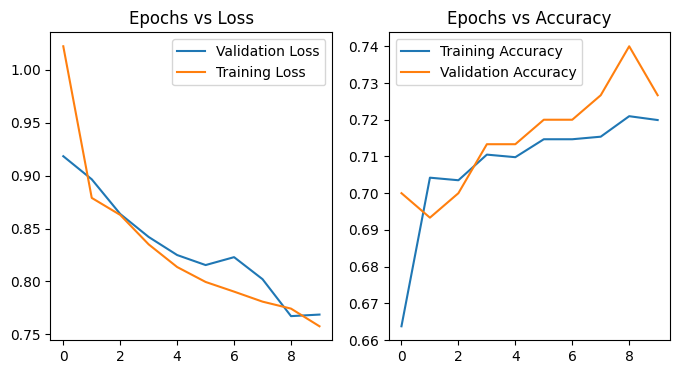


Learning curves for model: stacked_42


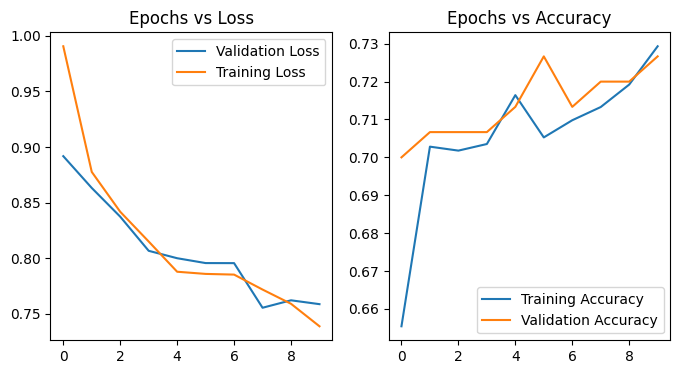


Learning curves for model: baseline_111


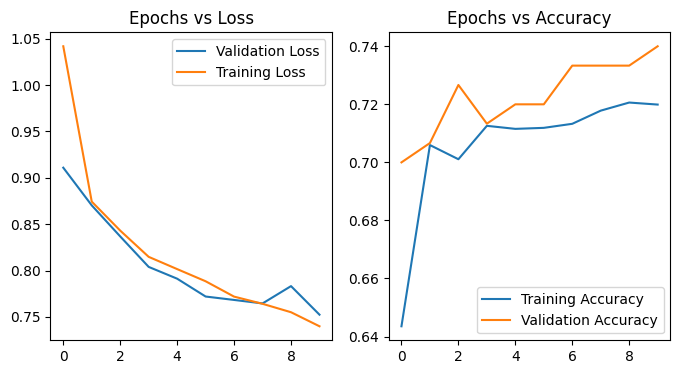


Learning curves for model: stacked_111


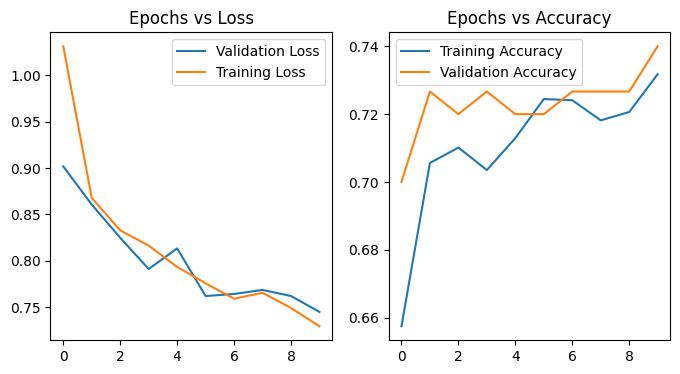


Learning curves for model: baseline_321


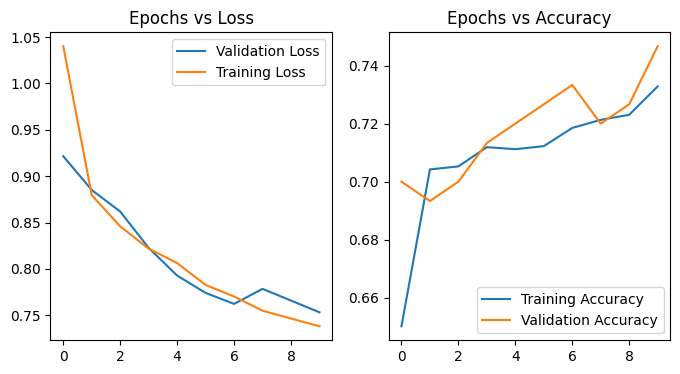


Learning curves for model: stacked_321


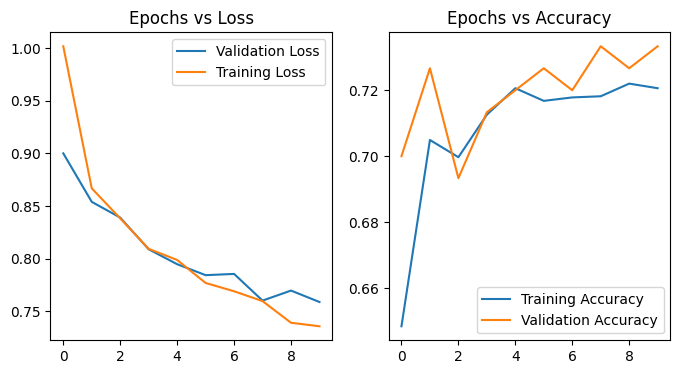

In [ ]:
print('Plotting Learning Curves for Bi-LSTM Models:')
for i, history in enumerate(histories):
    model_name = all_models[i].name
    print(f"\nLearning curves for model: {model_name}")
    plot_acc(history)

In [ ]:
print("For all models, checking scores and their deviation")
print(f"F1 Score: {np.mean(f1_scores):.4f} with STD: {np.std(f1_scores):.4f}")
print(f"Accuracy: {np.mean(accuracy_scores):.4f} with STD: {np.std(accuracy_scores):.4f}")
print(f"Accuracy: {np.mean(precision_scores):.4f} with STD: {np.std(precision_scores):.4f}")
print(f"Accuracy: {np.mean(recall_scores):.4f} with STD: {np.std(recall_scores):.4f}")


For all models, checking scores and their deviation
F1 Score: 0.3497 with STD: 0.0270
Accuracy: 0.7356 with STD: 0.0074
Accuracy: 0.4490 with STD: 0.0966
Accuracy: 0.3488 with STD: 0.0189


In [ ]:
# Check test accuracy
for model in all_models:
  y_pred_test = model.predict(X_test_padded)
  metrics = compute_metrics((y_pred_test, y_test))
  print(f"On test with {model.name} model: F1={metrics['f1']:.4f}, Acc={metrics['acc']:.4f}, Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
On test with baseline_42 model: F1=0.3329, Acc=0.6750, Precision=0.4436, Recall=0.3298
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step
On test with stacked_42 model: F1=0.3780, Acc=0.6821, Precision=0.4645, Recall=0.3641
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
On test with baseline_111 model: F1=0.3340, Acc=0.6679, Precision=0.4244, Recall=0.3323
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step
On test with stacked_111 model: F1=0.3565, Acc=0.6714, Precision=0.4585, Recall=0.3468
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
On test with baseline_321 model: F1=0.3490, Acc=0.6714, Precision=0.4196, Recall=0.3441
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step
On test with stacked_321 model: F1=0.3569, Acc=0.6857, Precision=0.4381, Recall=0.3551


In [ ]:
best_model = all_models[np.argmax(f1_scores)]
print(f'Best model is {best_model.name} with \nF1 score={max(f1_scores):.4f}, \nAccuracy={accuracy_scores[np.argmax(f1_scores)]:.4f}, \nPrecision={precision_scores[np.argmax(f1_scores)]}, \nRecall={recall_scores[np.argmax(f1_scores)]}')

Best model is baseline_321 with 
F1 score=0.3883, 
Accuracy=0.7467, 
Precision=0.45984848484848484, 
Recall=0.37148033126293994


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
              precision    recall  f1-score   support

           -       0.69      0.94      0.80       179
      DIRECT       0.62      0.24      0.35        62
 JUDGEMENTAL       0.00      0.00      0.00        18
    REPORTED       0.36      0.19      0.25        21

    accuracy                           0.67       280
   macro avg       0.42      0.34      0.35       280
weighted avg       0.61      0.67      0.61       280



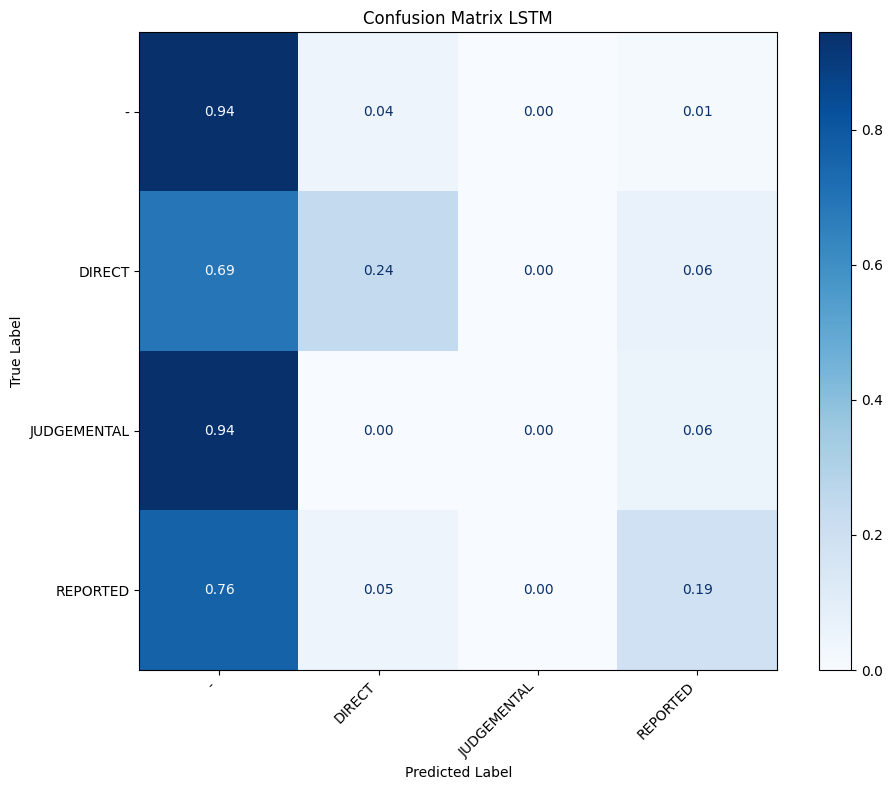

In [ ]:
y_pred_test = best_model.predict(X_test_padded)

# Convert to class labels
predicted_labels_lstm = np.argmax(y_pred_test, axis=-1);

# Classification report
print(classification_report(y_test, predicted_labels_lstm, target_names=label_encoding_reverse.values(), zero_division=False))

# Confusion matrix
cm = confusion_matrix(y_test, predicted_labels_lstm)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=label_encoding_reverse.values())

fig, ax = plt.subplots(figsize=(10, 8))
disp_normalized.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
plt.title('Confusion Matrix LSTM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



In [ ]:
# Inspect misclassified samples
ex = 0
print("Comparing")
for idx, (pred, label) in enumerate(zip(predicted_labels_lstm, y_test)):
    if pred != label and idx%5 == 0:
        ex += 1
        print(f"\n\nIndex: {idx}, Predicted: {label_encoding_reverse[pred]}, Actual: {label_encoding_reverse[label]}")
        print(df_test.iloc[idx]["tweet"])
    if ex >= 5:
      break

Comparing


Index: 20, Predicted: -, Actual: DIRECT
hot girl cant get nowher without a gps


Index: 35, Predicted: -, Actual: DIRECT
best way to do that be from behind her with your hand on her hip


Index: 40, Predicted: -, Actual: DIRECT
wait till ur husband mess up u gonna love the scouser death threat


Index: 50, Predicted: -, Actual: DIRECT
not as much a they harmkil woman and child by a long shot pun intend


Index: 80, Predicted: -, Actual: DIRECT
most woman nowaday look like this with no makeup hard to find the good one under ton of makeup alway go on a date to the beach lol


In [ ]:
ex = 0
print("Comparing only JUDGEMENTAL and REPORTED misclassifications")
for idx, (pred, label) in enumerate(zip(predicted_labels_lstm, y_test)):
    if pred != label and (label == 3 or label == 2):
        ex += 1
        print(f"\n\nIndex: {idx}, Predicted: {label_encoding_reverse[pred]}, Actual: {label_encoding_reverse[label]}")
        print(df_test.iloc[idx]["tweet"])
    if ex >= 5:
      break

Comparing only JUDGEMENTAL and REPORTED misclassifications


Index: 8, Predicted: -, Actual: REPORTED
kabul islam emir of afghanistan have announc the end of coeduc in the countri cite gender harassmentfemal student will attend univers on monday wednesday and saturday while tuesday thursday and sunday be fix for male


Index: 13, Predicted: -, Actual: REPORTED
the violent antifemin of a farright movement that see princip a vessel for breed a new white generat express itself in a fixat on a return to tradit gender rolesworth everi minut to read take 5 min out of your sun


Index: 28, Predicted: -, Actual: JUDGEMENTAL
dear fan can we not harass talent actor of color stop be racist douch nozzl this be whi we cant have nice thing mose be a badass inquisitor and yall cant handl her badassari


Index: 49, Predicted: -, Actual: REPORTED
im pretti sure it doe exist nick most serial killer be men who soley kill woman


Index: 52, Predicted: -, Actual: REPORTED
call to clean up parliament laddis

### ANALYSIS
To get the best out of the models we can create an esemble with soft voting to ensure better performance

In [ ]:
def ensemble_soft_vote(models, X_val):

    all_probs = [model.predict(X_val, verbose=0) for model in models]

    # average the model probs
    avg_probs = np.mean(all_probs, axis=0)

    # change to labels
    final_predictions = np.argmax(avg_probs, axis=1)

    return final_predictions

ensemble_pred = ensemble_soft_vote(all_models, X_val_padded)
ens_f1 = f1_score(y_val, ensemble_pred, average='macro')
ens_acc = accuracy_score(y_val, ensemble_pred)
ens_precision = precision_score(y_val, ensemble_pred, average='macro', zero_division=False)
ens_recall = recall_score(y_val, ensemble_pred, average='macro')

print(f"With Ensemble over probabilities from all models\nF1={ens_f1:.4f}, \nAccuracy={ens_acc:.4f}, \nPrecision={ens_precision:.4f}, \nRecall={ens_recall:.4f}")

With Ensemble over probabilities from all models
F1=0.3187, 
Accuracy=0.7333, 
Precision=0.3236, 
Recall=0.3298


### ANALYSIS
There are 6 models in total we can improve this by removing 2 lowest performing models based on F1 score and ensemble the other models

In [ ]:
top_model_indices = np.argsort(f1_scores)[-2:]
top_models = [all_models[i] for i in top_model_indices]
ensemble_pred = ensemble_soft_vote(top_models, X_val_padded)
ens_f1 = f1_score(y_val, ensemble_pred, average='macro')
ens_acc = accuracy_score(y_val, ensemble_pred)

ens_precision = precision_score(y_val, ensemble_pred, average='macro', zero_division=False)
ens_recall = recall_score(y_val, ensemble_pred, average='macro')

print(f"With Ensemble over probabilities from top 4 models\nF1={ens_f1:.4f}, \nAccuracy={ens_acc:.4f}, \nPrecision={ens_precision:.4f}, \nRecall={ens_recall:.4f}")

With Ensemble over probabilities from top 4 models
F1=0.3572, 
Accuracy=0.7400, 
Precision=0.4582, 
Recall=0.3506


# [Task 6 - 1.0 points] Transformers

In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).




### Relevant Material
- Tutorial 3

### Instructions
- **Load the Tokenizer and Model**

- **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

- **Train the Model**:
   Use the `Trainer` to train the model on your training data.

- **Evaluate the Model on the Test Set** using the same metrics used for LSTM-based models.

In [ ]:
!pip install transformers
!pip install datasets
!pip install accelerate -U
!pip install evaluate
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 17.1 MB/s eta 0:00:00


We'll renew the data without stemming and lemming to run the tokenizer for the specific transformer model. With that, we'll do some clean up on our data so it is consistent

In [ ]:
df_trans_train = downloadDataFromGitHub(url_temp + files[0])
df_trans_test = downloadDataFromGitHub(url_temp + files[1])
df_trans_val = downloadDataFromGitHub(url_temp + files[2])

In [ ]:
df_trans_train = handle_data(df_trans_train)
df_trans_test = handle_data(df_trans_test)
df_trans_val = handle_data(df_trans_val)

df_trans_train['label'] = df_trans_train['label'].map(label_encoding)
df_trans_test['label'] = df_trans_test['label'].map(label_encoding)
df_trans_val['label'] = df_trans_val['label'].map(label_encoding)


In [ ]:
y_trans_train = df_trans_train['label'].values
y_trans_val = df_trans_val['label'].values
y_trans_test = df_trans_test['label'].values

df_trans_train.head()

,id_EXIST,lang,tweet,label
200001,200001,en,FFS! How about laying the blame on the bastard...,0
200002,200002,en,Writing a uni essay in my local pub with a cof...,3
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,3
200004,200004,en,@GMB this is unacceptable. Use her title as yo...,0
200005,200005,en,‘Making yourself a harder target’ basically bo...,0


In [ ]:
# Preprocess for the model_card
def preprocess_trans(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

df_trans_train['tweet'] = df_trans_train['tweet'].apply(preprocess_trans)
df_trans_test['tweet'] = df_trans_test['tweet'].apply(preprocess_trans)
df_trans_val['tweet'] = df_trans_val['tweet'].apply(preprocess_trans)

df_trans_train.head()

,id_EXIST,lang,tweet,label
200001,200001,en,FFS! How about laying the blame on the bastard...,0
200002,200002,en,Writing a uni essay in my local pub with a cof...,3
200003,200003,en,@user it is 2021 not 1921. I dont appreciate t...,3
200004,200004,en,@user this is unacceptable. Use her title as y...,0
200005,200005,en,‘Making yourself a harder target’ basically bo...,0


In [ ]:
from transformers import AutoTokenizer

model_card = "cardiffnlp/twitter-roberta-base-hate"
tokenizer = AutoTokenizer.from_pretrained(model_card)

config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
from datasets import Dataset

def preprocess_text(texts):
    return tokenizer(texts['tweet'], truncation=True, max_length=120)

# Convert pandas DataFrames to Hugging Face Dataset objects
ds_trans_train = Dataset.from_pandas(df_trans_train)
ds_trans_test = Dataset.from_pandas(df_trans_test)
ds_trans_val = Dataset.from_pandas(df_trans_val)

# Apply preprocessing using Dataset.map with batched=True
ds_trans_train = ds_trans_train.map(preprocess_text, batched=True)
ds_trans_test = ds_trans_test.map(preprocess_text, batched=True)
ds_trans_val = ds_trans_val.map(preprocess_text, batched=True)

print(ds_trans_train)
print(ds_trans_test)
print(ds_trans_val)

Map:   0%|          | 0/2867 [00:00<?, ? examples/s]

Map:   0%|          | 0/280 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 2867
})
Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 280
})
Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 150
})


In [ ]:
print(ds_trans_train['input_ids'][12][:9])

[0, 2709, 2512, 9, 768, 4, 2780, 18, 386]


In [ ]:
print(ds_trans_train['attention_mask'][12][:9])

[1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
original_text = ds_trans_train['tweet'][9]
decoded_text = tokenizer.decode(ds_trans_train['input_ids'][9])

print(original_text[:200])
print()
print()
print(decoded_text[:200])

I guess that’s fairly normal for a Neanderthal http


<s>I guess that’s fairly normal for a Neanderthal http</s>


In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    model_card,
    num_labels=4,
    id2label=label_encoding_reverse,
    label2id=label_encoding,
    ignore_mismatched_sizes=True
)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(model)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
import evaluate

acc_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')
precision_metric = evaluate.load('precision')
recall_metric = evaluate.load('recall')

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
def compute_metrics_trans(output_info):
    predictions, labels = output_info
    predictions = np.argmax(predictions, axis=-1)

    f1 = f1_metric.compute(predictions=predictions, references=labels, average='macro')
    acc = acc_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average='macro', zero_division=0)
    recall = recall_metric.compute(predictions=predictions, references=labels, average='macro', zero_division=0)

    return {**f1, **acc, **precision, **recall}

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="test_dir",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to='none'
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_trans_train,
    eval_dataset=ds_trans_val,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_trans,
)

In [ ]:
trainer.train()

# Save the best transformer model explicitly
trainer.save_model("/content/drive/My Drive/nlp_assignment1_transformer_best_model")


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,No log,0.609036,0.419156,0.780000,0.474407,0.449819


# [Task 7 - 0.5 points] Error Analysis

After evaluating the model, perform a brief error analysis on the **test set**:

### Instructions

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.

In [ ]:
test_prediction_info = trainer.predict(ds_trans_test)
test_predictions = test_prediction_info.predictions
test_labels = test_prediction_info.label_ids

print(test_predictions.shape)
print(test_labels.shape)

(280, 4)
(280,)


In [ ]:
test_metrics = compute_metrics_trans([test_predictions, test_labels])
print(test_metrics)

{'f1': 0.460308972073678, 'accuracy': 0.7785714285714286, 'precision': 0.46053740779768176, 'recall': 0.4730110101348162}


              precision    recall  f1-score   support

           -       0.85      0.93      0.89       179
      DIRECT       0.66      0.77      0.71        62
 JUDGEMENTAL       0.00      0.00      0.00        18
    REPORTED       0.33      0.19      0.24        21

    accuracy                           0.78       280
   macro avg       0.46      0.47      0.46       280
weighted avg       0.71      0.78      0.74       280



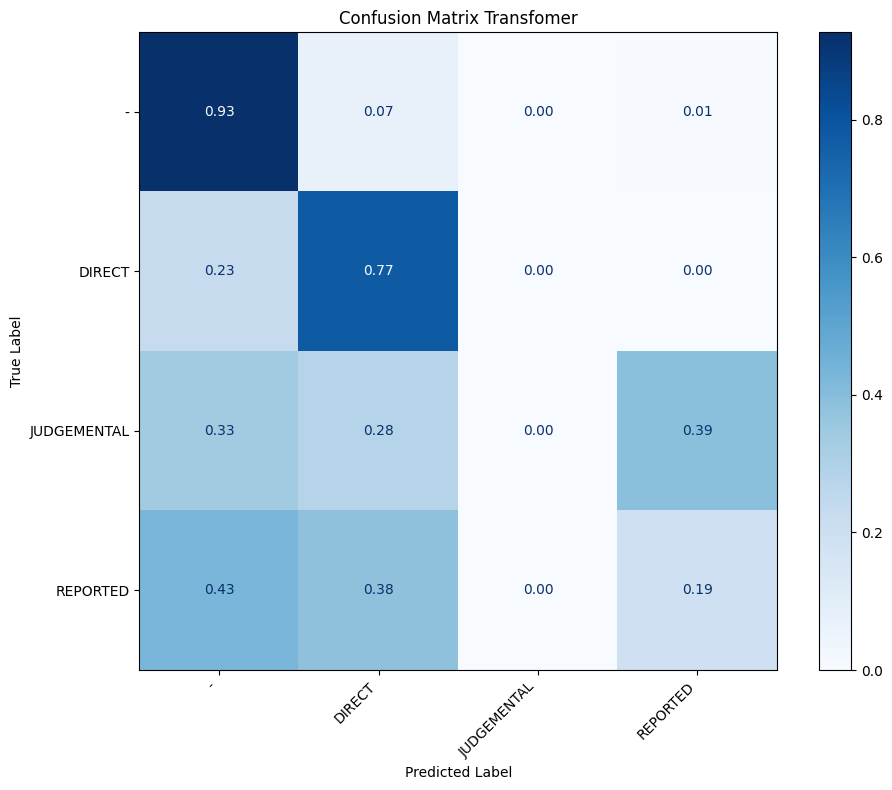

In [ ]:
# Convert to class labels
predicted_labels = np.argmax(test_predictions, axis=-1)

# Classification report
print(classification_report(test_labels, predicted_labels, target_names=label_encoding_reverse.values(), zero_division=False))

# Confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=label_encoding_reverse.values())

fig, ax = plt.subplots(figsize=(10, 8))
disp_normalized.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
plt.title('Confusion Matrix Transfomer')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# Inspect misclassified samples
ex = 0
print("Comparing")
for idx, (pred, label) in enumerate(zip(predicted_labels, test_labels)):
    if pred != label and idx%3 == 0:
        ex += 1
        print(f"\n\nIndex: {idx}, Predicted: {label_encoding_reverse[pred]}, Actual: {label_encoding_reverse[label]}")
        print(ds_trans_test[idx]["tweet"])
    if ex >= 5:
      break

Comparing


Index: 18, Predicted: DIRECT, Actual: -
@user How did we reach a point where blonks are having the audacity to talk about yoongis rap do y'all see who you Stan ? Are y'all ok ?? Your girls can't write can't deliver can't come close to bts's lyricism tf are y'all getting brave for ?? Fashion deals ??


Index: 21, Predicted: -, Actual: DIRECT
@user @user @user That gold digger is nice but the picture and set up for them are elite. Pinwork is like the revealing of the Mona Lisa. Always a work of art.


Index: 51, Predicted: REPORTED, Actual: -
@user @user @user Yup I hate when men rape and kill women. http


Index: 57, Predicted: DIRECT, Actual: -
Ladies, don't have a miscarriage in Louisiana! If you do, in addition to probably having your friends and family sued by some opportunistic yokel, you'll be charged with murder.  http


Index: 60, Predicted: -, Actual: DIRECT
"Dude Looks Like A Lady" 💫🎶Aerosmith🎶🎸⚡️💫https://t.co/41OxpV6YWm


In [ ]:
ex = 0
print("Comparing only JUDGEMENTAL and REPORTED misclassifications")
for idx, (pred, label) in enumerate(zip(predicted_labels, y_test)):
    if pred != label and (label == 3 or label == 2):
        ex += 1
        print(f"\n\nIndex: {idx}, Predicted: {label_encoding_reverse[pred]}, Actual: {label_encoding_reverse[label]}")
        print(df_test.iloc[idx]["tweet"])
    if ex >= 5:
      break

Comparing only JUDGEMENTAL and REPORTED misclassifications


Index: 8, Predicted: -, Actual: REPORTED
kabul islam emir of afghanistan have announc the end of coeduc in the countri cite gender harassmentfemal student will attend univers on monday wednesday and saturday while tuesday thursday and sunday be fix for male


Index: 13, Predicted: -, Actual: REPORTED
the violent antifemin of a farright movement that see princip a vessel for breed a new white generat express itself in a fixat on a return to tradit gender rolesworth everi minut to read take 5 min out of your sun


Index: 28, Predicted: -, Actual: JUDGEMENTAL
dear fan can we not harass talent actor of color stop be racist douch nozzl this be whi we cant have nice thing mose be a badass inquisitor and yall cant handl her badassari


Index: 37, Predicted: DIRECT, Actual: REPORTED
whi would a woman accus someon of hit her if it be lie i dont hit woman and never be accus of sucheven my exnev say that in a nasti divorc


Index: 49, P

## Error Analysis
1. It is evident that both Bidirectional-LSTM and Transfomer architecture are struggling with the class imbalance issue in the dataset and model's bias toward majority class.
2. None of the architectures/model (Bi-LSTM or Transformer) were able to differentiate "JUDGEMENTAL" tweets.
3. Transfomer is better at differentiating from top 2 classes with most data available in the dataset, namely, "-" and "DIRECT" tweets.
4. Overall the Transfomer model got a higher f1-macro score (0.46) compared to the best Bi-LSTM model (0.34)

## Possible Solutions
1. We can try and over-sample from the minorty classes to train the models better on these classes
2. Or assign higher weights to minorty classes during model training

# [Task 8 - 0.5 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is **not a copy-paste** of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.


# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

## Bonus Points
Bonus points are arbitrarily assigned based on significant contributions such as:
- Outstanding error analysis
- Masterclass code organization
- Suitable extensions

**Note**: bonus points are only assigned if all task points are attributed (i.e., 6/6).

**Possible Suggestions for Bonus Points:**
- **Try other preprocessing strategies**: e.g., but not limited to, explore techniques tailored specifically for tweets or  methods that are common in social media text.
- **Experiment with other custom architectures or models from HuggingFace**
- **Explore Spanish tweets**: e.g., but not limited to, leverage multilingual models to process Spanish tweets and assess their performance compared to monolingual models.

# FAQ

Please check this frequently asked questions before contacting us

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.


### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Robust Evaluation

Each model is trained with at least 3 random seeds.

Task 5 requires you to compute the average performance over the 3 seeds and its corresponding standard deviation.

### Expected Results

Task 2 leaderboard reports around 40-50 F1-score.
However, note that they perform a hierarchical classification.

That said, results around 30-40 F1-score are **expected** given the task's complexity.

### Model Selection for Analysis

To carry out the error analysis you are **free** to either

* Pick examples or perform comparisons with an individual seed run model (e.g., Baseline seed 1337)
* Perform ensembling via, for instance, majority voting to obtain a single model.

### Error Analysis

Some topics for discussion include:
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.


# The End

Feel free to reach out for questions/doubts!